**In this notebook, we are trying to classify the skin cancer into Malignant and Benign. We will use teo approaches. First we will use a simple Convolutional Neural Netowk and secondly we will use transfer learning in another notebook. This is mainly to compare the performance between the two models and see how transfer learning can increase the accuray specially when we do not have the needed amount of data.**

First of all we will import all the packages we will need.

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt 
import h5py

- Secondly, we will prepare the data. For this we will use the keras API named "ImageDataGenerator" that we imorted as "IDG".
- The data we will used is saved in the directory "../input/skin-cancer-malignant-vs-benign". It is splitted into two directories, training and test.
- The ImageDataGenerator API will use the directories names to get the labels of the data.
- We will use data augmentation as a technique to increase the size of the data set and to avoid the model with cases that may not be covered in the available short dataset.
- The ImageDataGenerator will care for the data augmentation augmentation along with the data loading.

In [2]:
training_data_dir = '../input/skin-cancer-malignant-vs-benign/train'
testing_data_dir = '../input/skin-cancer-malignant-vs-benign/test'
training_data_generator = IDG(
                              rescale = 1./255,   #normalize the image pixels values to be between 0 & 1
                              rotation_range = 40,
                              width_shift_range = 0.2,
                              height_shift_range = 0.2,
                              shear_range = 0.2,
                              zoom_range = 0.2,
                              horizontal_flip = True,
                              fill_mode = 'nearest'
                             )
testing_data_generator = IDG(rescale = 1./255)
training_data = training_data_generator.flow_from_directory(
                                                            training_data_dir,
                                                            target_size = (150, 150),
                                                            batch_size = 32,
                                                            class_mode = 'binary'
                                                            )
testing_data = testing_data_generator.flow_from_directory(
                                                            testing_data_dir,
                                                            target_size = (150, 150),
                                                            batch_size = 32,
                                                            class_mode = 'binary'
                                                            )
training_data.class_indices

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


{'benign': 0, 'malignant': 1}

Next, we will define our model. As mentioned in the introduction, this notebook is one of two notebooks solving this problem with two approaches. In this notebook we will use a simple model that is as follows:
- Conv2D >> BatchNormalization >> MaxPooling >> Conv2D >> BatchNormalization >> MaxPooling >> Conv2D >> BatchNormalization >> MaxPooling >> Flatten >> Dense >> Dropout >> Dense (output layer).

In [3]:
model = tf.keras.Sequential([
                            Conv2D(64, (3, 3), input_shape = (150, 150, 3)),
                            BatchNormalization(),
                            MaxPool2D(2),
                            Conv2D(64, (3, 3)),
                            BatchNormalization(),
                            MaxPool2D(2),
                            Conv2D(128, (3, 3)),
                            BatchNormalization(),
                            MaxPool2D(2),
                            Conv2D(128, (3, 3), input_shape = (150, 150, 3)),
                            BatchNormalization(),
                            MaxPool2D(2),
                            Flatten(),
                            Dense(256, activation = 'relu'),
                            Dropout(rate = 0.2),
                            Dense(128, activation = 'relu'),
                            Dense(1, activation = 'sigmoid')
])


model.compile(optimizer = Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()     # To summarize the model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       7

Now, before we go through training our model, we will define a class called "myCallback". The purpose of creating that class will be to save the weights of the best model. The best model is the model with the highest Validation accuracy.

In [4]:
saved_weights = 'best_weights.hdf5'

checkpoint = ModelCheckpoint(filepath = saved_weights, monitor = 'val_accuracy', save_best_only = True, save_weights_only = True)

callback = [checkpoint]

Now, we are ready to train our model.

In [5]:
history = model.fit(training_data, epochs = 300 , validation_data = testing_data, callbacks = callback)

Epoch 1/300
83/83 [==============================] - 46s 475ms/step - loss: 0.8904 - accuracy: 0.7146 - val_loss: 1.1503 - val_accuracy: 0.5485
Epoch 2/300
83/83 [==============================] - 22s 269ms/step - loss: 0.6743 - accuracy: 0.7476 - val_loss: 0.5439 - val_accuracy: 0.6621
Epoch 3/300
83/83 [==============================] - 21s 253ms/step - loss: 0.5134 - accuracy: 0.7791 - val_loss: 0.5926 - val_accuracy: 0.6061
Epoch 4/300
83/83 [==============================] - 22s 268ms/step - loss: 0.4685 - accuracy: 0.7865 - val_loss: 0.5378 - val_accuracy: 0.6970
Epoch 5/300
83/83 [==============================] - 23s 275ms/step - loss: 0.4627 - accuracy: 0.7831 - val_loss: 0.5111 - val_accuracy: 0.7773
Epoch 6/300
83/83 [==============================] - 22s 261ms/step - loss: 0.4429 - accuracy: 0.7901 - val_loss: 0.5004 - val_accuracy: 0.7303
Epoch 7/300
83/83 [==============================] - 22s 269ms/step - loss: 0.4060 - accuracy: 0.7998 - val_loss: 0.4566 - val_accuracy:

In [6]:
#model.load_weights(saved_weights)

In [7]:
#history = model.fit(training_data, epochs = 10, validation_data = testing_data, callbacks = callback)

Now we are done. Before testing the model in a new image, Let's see how both the Accuracy (training, testing) and the loss (training, test) changed during training.

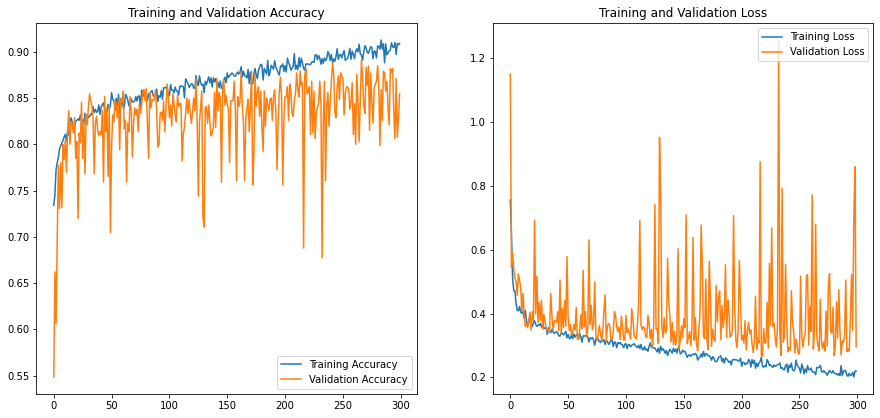

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()